# Notes on saturation Vapor Pressure #

There are a large number of expressions for the saturation vapor pressure in the literature, and many of these, even recent ones, seem to reference previous studies in a haphazard way.  So how much do these differ, is there a standard, and by what criteria should one judge them by.  These are big questions, and I won't answer them comprehensively here, but perhaps a bit of insight can be shared.

The first thing to note is that there is a community that concerns itself with this question.  They call themselves the international association for the physical properties of water and steam, and mostly concern themselves with the behavior of water at high temperature.  The approach of the IAPWS is to develop an empirical equation of state for water, in the form of a specification of its Helmholtz free energy, from which all other properties can be derived.  The standard reference for the IAPWS equation of state is the publication by Wagner and Pru{\ss} (Thermodynamic Properties of Ordinary Water) published in 2002 and which describes the IAPWS-95 approved formulation.  Minor corrections have since been made to this, which as best I can tell are relevant at high temperatures.   By working with an equation of state, all properties of water, from the specific heats to the gas constants to the phase-change enthalpies can be derived consistently.  The disadvantage of this approach is that the equation is derived by positing an analytic form that is then fit to a very wide and diverse abundance of existing data.  The resultant equation is described in an ideal part, which involves a summation of nine terms and thirteen coefficients, and a residual part, with more than 50 terms and over 200 constants.

For the case of the saturation vapor pressure over water Wagner and Pru{\ss} suggest a much simpler equation that is described in terms of only six coefficients. First, below I compare the relative error to the IAPWS standard as has been formlated and distributed in the iapws python package, version (1.4).  There has been some discussion on the web of its implementation, but the similarity with the Wagner and Pru{\ss} formulation gives me confidence.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import interpolate, optimize

plot_dir = '/Users/m219063/Research/Projects/Thermodynamics/plots/'

!%matplotlib inline

/bin/sh: line 0: fg: no job control


In [2]:
gravity = 9.8076

cpd     = 1006.
Rd      = 287.05

Rv      = 461.53    # IAPWS97 at 273.15
cpv     = 1865.01   # ''
lv0     = 2500.93e3 # IAPWS97 at 273.15
lf0     =  333.42e3 #''

cl      = 4179.57   # IAPWS97 at 305 and P=0.1 MPa (chosen to give a good fit for es over ice)
ci      = 1905.43   # IAPWS97 at 247.065 and P=0.1 MPa (chosen to give a good fit for es over ice)

eps1     = Rd/Rv
eps2     = Rv/Rd -1.

P0      = 100000.  # Standard Pressure
T0      = 273.15   # Standard Temperature
PvC     = 22.064e6 # Critical pressure of water vapor
TvC     = 647.096  # Critical temperature of water vapor
TvT     = 273.16   # Triple point temperature of water
PvT     = 611.655
lvT     = lv0 + (cpv-cl)*(TvT-T0)
lfT     = lf0 + (cpv-ci)*(TvT-T0)
lsT     = lvT + lfT

es_default = 'sonntag'

def thermo_input(x, xtype='none'):
    
    import numpy as np

    x = np.asarray(x).flatten()
    scalar_input = False
    if x.ndim == 0:
        x = x[None]  # Makes x 1D
        scalar_input = True

    if (xtype == 'Kelvin' and x.max() < 100 ): x = x+273.15
    if (xtype == 'Celcius'and x.max() > 100 ): x = x-273.15
    if (xtype == 'Pascal' and x.max() < 1200): x = x*100.
    if (xtype == 'kg/kg'  and x.max() > 1.0) : x = x/1000.
    if (xtype == 'meter'  and x.max() < 10.0): print('Warning: input should be in meters, max value less than 10, not corrected')

    return x, scalar_input

def eslf(T, formula=es_default):
    """ Returns the saturation vapour pressure [Pa] over liquid given 
	the temperature.  Temperatures can be in Celcius or Kelvin.
	Formulas supported are
	  - Goff-Gratch (1994 Smithsonian Tables)
	  - Sonntag (1994) 
	  - Flatau
	  - Magnus Tetens (MT)
      - Romps (2017)
      - Mpurhpy-Koop
      - Bolton
      - Wagner and Pruss (WP, 2002) is the default
	>>> eslf(273.16)
	611.657
    """
    import numpy as np

    x,  scalar_input = thermo_input(T, 'Kelvin')

    if formula == "flatau":
        if (np.min(x) > 100): x = x-273.16
        np.maximum(x,-80.)
        c_es= np.asarray([0.6105851e+03, 0.4440316e+02, 0.1430341e+01, 0.2641412e-01,
                           0.2995057e-03,0.2031998e-05,0.6936113e-08,0.2564861e-11,-0.3704404e-13])
        es = np.polyval(c_es[::-1],x)
    elif formula == "bolton":
        if (np.min(x) > 100): x = x-273.15
        es = 611.2*np.exp((17.67*x)/(243.5+x))
    elif formula == "sonntag":
        xx = -6096.9385/x + 16.635794 - 2.711193e-2*x + 1.673952e-5*x*x + 2.433502 * np.log(x)
        es = 100.*np.exp(xx)
    elif formula =='goff-gratch':
        x1 = 273.16/x
        x2 = 373.16/x
        xl = np.log10(1013.246 ) - 7.90298*(x2 - 1) + 5.02808*np.log10(x2) - 1.3816e-7*(10**(11.344*(1.-1./x2)) - 1.0) + 8.1328e-3 * (10**(-3.49149*(x2-1)) - 1.0)
        es =10**(xl+2) # plus 2 converts from hPa to Pa
    elif formula == 'wagner-pruss':
        vt = 1.-x/TvC
        es = PvC * np.exp(TvC/x * (-7.85951783*vt + 1.84408259*vt**1.5 - 11.7866497*vt**3 + 22.6807411*vt**3.5 - 15.9618719*vt**4 + 1.80122502*vt**7.5))
    elif formula == 'hardy98':
        y  = -2.8365744e+3/(x*x) - 6.028076559e+3/x + 19.54263612 - 2.737830188e-2*x + 1.6261698e-5*x**2 + 7.0229056e-10*x**3 - 1.8680009e-13*x**4 + 2.7150305 * np.log(x)
        es = np.exp(y)
    elif formula == 'romps':
        Rr    = 461.
        cvl_r = 4119
        cvv_r = 1418
        cpv_r = cvv_r + Rr
        es = 611.65 * (x/TvT) **((cpv_r-cvl_r)/Rr) * np.exp((2.37403e6 - (cvv_r-cvl_r)*TvT)*(1/TvT - 1/x)/Rr)
    elif formula == "murphy-koop":
        es = np.exp(54.842763 - 6763.22/x - 4.210*np.log(x) + 0.000367*x + np.tanh(0.0415*(x - 218.8)) * (53.878 - 1331.22/x - 9.44523 * np.log(x) + 0.014025*x))
    elif formula == "standard-analytic":
        c1 = (cpv-cl)/Rv
        c2 = lvT/(Rv*TvT) - c1
        es = PvT * np.exp(c2*(1.-TvT/x)) * (x/TvT)**c1
    else:
        exit("formula not supported")

    es = np.maximum(es,0)
    if scalar_input:
        return np.squeeze(es)
    return es

def esif(T, formula=es_default):
    """ Returns the saturation vapour pressure [Pa] over ice given 
	the temperature.  Temperatures can be in Celcius or Kelvin.
	uses the Goff-Gratch (1994 Smithsonian Tables) formula
	>>> esli(273.15)
	6.112
m    """
    import numpy as np

    x,  scalar_input = thermo_input(T, 'Kelvin')

    if formula == "sonntag":
        es = 100 * np.exp(24.7219 - 6024.5282/x + 0.010613868*x - 0.000013198825*x**2 - 0.49382577*np.log(x))
    elif formula == "goff-gratch":
        x1 = 273.16/x
        xi = np.log10(   6.1071) - 9.09718*(x1 - 1) - 3.56654*np.log10(x1) + 0.876793*(1 - 1./x1)
        es = 10**(xi+2)
    elif formula == "wagner-pruss": #(actually wagner et al, 2011)
        a1 = -0.212144006e+2
        a2 =  0.273203819e+2
        a3 = -0.610598130e+1
        b1 =  0.333333333e-2
        b2 =  0.120666667e+1
        b3 =  0.170333333e+1
        theta = T/TvT
        es = PvT * np.exp((a1*theta**b1 + a2 * theta**b2 + a3 * theta**b3)/theta)
    elif formula == "murphy-koop":
        es = np.exp(9.550426 - 5723.265/x + 3.53068 * np.log(x) - 0.00728332*x)
    elif formula == "romps":
        Rr    = 461.
        cvv_r = 1418.
        cvs_r = 1861.
        cpv_r = cvv_r + Rr
        es = 611.65 * (x/TvT) **((cpv_r-cvs_r)/Rr) * np.exp((2.37403e6 + 0.33373e6 - (cvv_r-cvs_r)*TvT)*(1/TvT - 1/x)/Rr)
    elif formula == "standard-analytic":
        c1 = (cpv-ci)/Rv
        c2 = lsT/(Rv*TvT) - c1
        es = PvT * np.exp(c2*(1.-TvT/x)) * (x/TvT)**c1
    else:
        exit("formula not supported")

    es = np.maximum(es,0)
    if scalar_input:
        return np.squeeze(es)
    return es
 
def esilf(T,formula=es_default):
    import numpy as np
    return np.minimum(esif(T,formula),eslf(T,formula))

def es(T,formula=es_default,state='liq'):

    import numpy as np
    
    x,  scalar_input = thermo_input(T, 'Kelvin')

    if (state == 'liq'):
        return eslf(x,formula)
    if (state == 'ice'):
        return esif(x,formula)
    if (state == 'mxd'):
        return esilf(x,formula)

def des(T,formula=es_default,state='liq'):

    import numpy as np
    
    x,  scalar_input = thermo_input(T, 'Kelvin')
    dx = 0.01; xp = x+dx/2; xm = x-dx/2
    return (es(xp,formula,state)-es(xm,formula,state))/dx

def dlnesdlnT(T,formula=es_default,state='liq'):

    import numpy as np
    
    x,  scalar_input = thermo_input(T, 'Kelvin')
    dx = 0.01; xp = x+dx/2; xm = x-dx/2
    return ((es(xp,formula,state)-es(xm,formula,state))/es(x,formula,state) * (x/dx))
   
def phase_change_enthalpy(Tx,fusion=False):
    """ Returns the enthlapy [J/g] of vaporization (default) of water vapor or 
    (if fusion=True) the fusion anthalpy.  Input temperature can be in degC or Kelvin
    >>> phase_change_enthalpy(273.15)
    2500.8e3
    """
    import numpy as np

    TC, scalar_input = thermo_input(Tx, 'Celcius')
    TK, scalar_input = thermo_input(Tx, 'Kelvin')

    if (fusion):
        el = lfT + (cl-ci)*(TK-TvT)
    else:
        el = lvT + (cpv-cl)*(TK-TvT)

    if scalar_input:
        return np.squeeze(el)
    return el
    

## Some baic properties of water from the IAWPS routines. ##

Using IAPWS Version 1.4



/Users/m219063/opt/anaconda3/lib/python3.7/site-packages/iapws/_iapws.py:124: UserWarning: Metastable ice
  warnings.warn("Metastable ice")


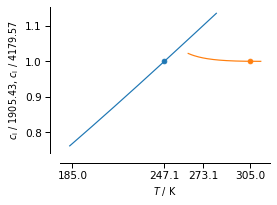

In [11]:
import iapws

print ('Using IAPWS Version %s\n'%(iapws.__version__,))
T = np.arange(183.15,313.15)
ci_iapws = np.full(len(T),np.nan)
cl_iapws = np.full(len(T),np.nan)
for i,Tx in enumerate(T):
    if (Tx < 283): ci_iapws[i] =  iapws._iapws._Ice(Tx, 0.1)['cp']*1000 / ci
    if (Tx > 263): cl_iapws[i] =  iapws._iapws._Liquid(Tx, 0.1)['cp']*1000 / cl

fig = plt.figure(figsize=(4,3))

ax1 = plt.subplot(1,1,1)
ax1.set_xlabel('$T$ / K')
ax1.set_ylabel('$c_\mathrm{i}$ / %5.2f, $c_\mathrm{l}$ / %5.2f'%(ci,cl))
ax1.set_xticks([185,247.07,273.15,305.00])
plt.scatter([247.065],[1.])
plt.scatter([305.000],[1.])
plt.plot(T,ci_iapws)
plt.plot(T,cl_iapws)

sns.set_context("paper", font_scale=1.2)
sns.despine(offset=10)

plt.tight_layout()
fig.savefig(plot_dir+'cp-Tdependance.pdf')

TK = np.arange(273.15,315.15,0.01)
es_iapws = np.zeros(len(TK))
for i, x in enumerate(TK):
    es_iapws[i] = iapws.iapws97._PSat_T(x) *1.e6 #Temperature, [K]; Returns:Pressure, [MPa]

## Behavior of saturation vapor pressure above the triple point ##

This comparison of relative error suggests that the Wagner-Pru{\ss}, Murphy and Koop, Hardy, and Sonntag formulations lie closest to the IAPWS-97 reference.  Romps (2017) and Bolton (1980) are similarly accurate and may have advantages.  Hardy is interesting as it appears in a technical document and is rarely mentioned in the subsequent literature, but used by Vaisala in the calibration of their sondes

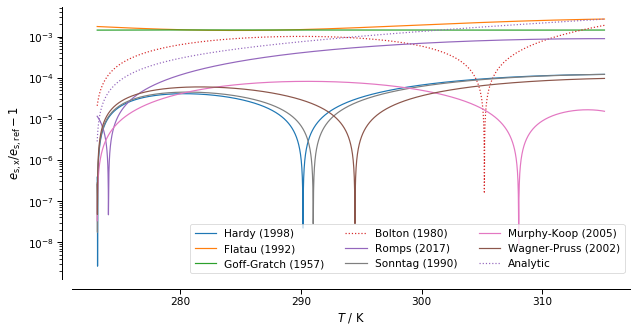

In [4]:

state = 'liq'
fig = plt.figure(figsize=(10,5))
ax1 = plt.subplot(1,1,1)
ax1.set_xlabel('$T$ / K')
ax1.set_ylabel('$e_{\mathrm{s,x}}/e_{\mathrm{s,ref}} - 1$')
ax1.set_yscale('log')

es_ref = es_iapws
es_w = es(TK,formula="wagner-pruss",state=state)
es_r = es(TK,formula='romps',state=state)
es_g = es(TK,formula='goff-gratch',state=state)
es_m = es(TK,formula='murphy-koop',state=state)
es_s = es(TK,formula='sonntag',state=state)
es_b = es(TK,formula='bolton',state=state)
es_f = es(TK,formula='flatau',state=state)
es_h = es(TK,formula='hardy98',state=state)
es_a = es(TK,formula='standard-analytic',state=state)

plt.plot(TK,np.abs(es_h/es_ref-1),c='tab:blue',ls='solid',label='Hardy (1998)')
plt.plot(TK,np.abs(es_f/es_ref-1),c='tab:orange',label='Flatau (1992)')
plt.plot(TK,np.abs(es_g/es_ref-1),c='tab:green',label='Goff-Gratch (1957)')
plt.plot(TK,np.abs(es_b/es_ref-1),c='tab:red',ls='dotted',label='Bolton (1980)')

plt.plot(TK,np.abs(es_r/es_ref-1),c='tab:purple',label='Romps (2017)')
plt.plot(TK,np.abs(es_s/es_ref-1),c='tab:grey',label='Sonntag (1990)')
plt.plot(TK,np.abs(es_m/es_ref-1),c='tab:pink',label='Murphy-Koop (2005)')
plt.plot(TK,np.abs(es_w/es_ref-1),c='tab:brown',label='Wagner-Pruss (2002)')
plt.plot(TK,np.abs(es_a/es_ref-1),c='tab:purple',ls='dotted',label='Analytic')

plt.legend(loc="lower right",ncol=3)

sns.set_context("paper", font_scale=1.2)
sns.despine(offset=10)

fig.savefig(plot_dir+'es_l-error.pdf')

## Extension to temperatures below the triple point ##

To extend over the entire temperature range a different reference is required, for this any of the Hardy, Sonntag, Murphy-Koop and Wagner-Pru{\ss} formulations could suffice.  We choose Wagner-Pru{\ss} because Wagner's group is responsible for the standard, and has also developed the IAPWS standard for saturation vapor pressure over ice.  Below the results are plooted with respect to this standard over a much larger temperature range.

It is not clear how accurate Wagner and Pru{\ss} wis hen extended well beyond the IAPWS range, based on which it might be that the grouping of errors of similar magnitude from the Bolton, Flatau and Goff-Gratch formulations are indicative of a low temperature bias in the Wagner-Pru{\ss} formualtion.  I doubt that this is the case, as the poor performance of all these formulations in the higher temperature range, and the simplicity of their formulation make it unlikely.   The agreement of the Murphy-Koop formulation with these simpler formulations at low temperature may be indicative of Murphy and Koops focus on saturation over ice rather than liquid.

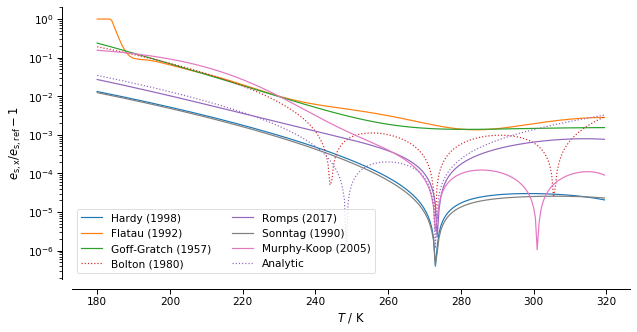

In [5]:
state = 'liq'
fig = plt.figure(figsize=(10,5))
ax1 = plt.subplot(1,1,1)
ax1.set_xlabel('$T$ / K')
ax1.set_ylabel('$e_{\mathrm{s,x}}/e_{\mathrm{s,ref}} - 1$')
ax1.set_yscale('log')

TK = np.arange(180,320,0.5)

es_w = es(TK,formula="wagner-pruss",state=state)
es_r = es(TK,formula='romps',state=state)
es_g = es(TK,formula='goff-gratch',state=state)
es_m = es(TK,formula='murphy-koop',state=state)
es_s = es(TK,formula='sonntag',state=state)
es_b = es(TK,formula='bolton',state=state)
es_f = es(TK,formula='flatau',state=state)
es_h = es(TK,formula='hardy98',state=state)
es_a = es(TK,formula='standard-analytic',state=state)

es_ref = es_w

plt.plot(TK,np.abs(es_h/es_ref-1),c='tab:blue',ls='solid',label='Hardy (1998)')
plt.plot(TK,np.abs(es_f/es_ref-1),c='tab:orange',label='Flatau (1992)')
plt.plot(TK,np.abs(es_g/es_ref-1),c='tab:green',label='Goff-Gratch (1957)')
plt.plot(TK,np.abs(es_b/es_ref-1),c='tab:red',ls='dotted',label='Bolton (1980)')

plt.plot(TK,np.abs(es_r/es_ref-1),c='tab:purple',label='Romps (2017)')
plt.plot(TK,np.abs(es_s/es_ref-1),c='tab:grey',label='Sonntag (1990)')
plt.plot(TK,np.abs(es_m/es_ref-1),c='tab:pink',label='Murphy-Koop (2005)')
plt.plot(TK,np.abs(es_a/es_ref-1),c='tab:purple',ls='dotted',label='Analytic')

#plt.plot(TK,np.abs(es_w/es_ref-1),c='tab:olive',label='Wagner-Pruss (2002)')

plt.legend(loc="lower left",ncol=2)

sns.set_context("paper", font_scale=1.2)
sns.despine(offset=10)

fig.savefig(plot_dir+'es_lsc-error.pdf')

## Saturation vapor pressure over ice ##

A subset of the formulations also postulate forms for the saturation vapor pressure over ice.  For the reference in this quantity we use Wagner et al., (2011) as this has been adopted as the IAPWS standard.   Here is seems that Murphy and Koop's (2005) formulation behaves very well in comparision to Wagner et al., but Sonntag is also quite adequate, particularly at lower ($T<273.15$ K) temperatures where it is likely to be applied.

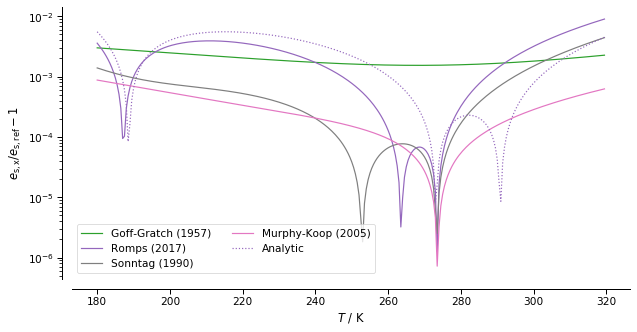

In [6]:
state = 'ice'
fig = plt.figure(figsize=(10,5))
ax1 = plt.subplot(1,1,1)
ax1.set_xlabel('$T$ / K')
ax1.set_ylabel('$e_{\mathrm{s,x}}/e_{\mathrm{s,ref}} - 1$')
ax1.set_yscale('log')

TK = np.arange(180,320,0.5)

es_w = es(TK,formula="wagner-pruss",state=state)
es_r = es(TK,formula='romps',state=state)
es_g = es(TK,formula='goff-gratch',state=state)
es_m = es(TK,formula='murphy-koop',state=state)
es_s = es(TK,formula='sonntag',state=state)
es_a = es(TK,formula='standard-analytic',state=state)
es_ref = es_w

plt.plot(TK,np.abs(es_g/es_ref-1),c='tab:green',label='Goff-Gratch (1957)')
plt.plot(TK,np.abs(es_r/es_ref-1),c='tab:purple',label='Romps (2017)')
plt.plot(TK,np.abs(es_s/es_ref-1),c='tab:grey',label='Sonntag (1990)')
plt.plot(TK,np.abs(es_m/es_ref-1),c='tab:pink',label='Murphy-Koop (2005)')
plt.plot(TK,np.abs(es_a/es_ref-1),c='tab:purple',ls='dotted',label='Analytic')

#plt.plot(TK,np.abs(es_w/es_ref-1),c='tab:olive',label='Wagner-Pruss (2002)')

plt.legend(loc="lower left",ncol=2)

sns.set_context("paper", font_scale=1.2)
sns.despine(offset=10)

fig.savefig(plot_dir+'es_i-error.pdf')

## Clausius Clapeyron ##

Often over looked is that many conceptual models are built on the application of the Clausius-Clapeyron equation,
\begin{equation} 
\frac{\mathrm{d} \ln e_\mathrm{s}}{\mathrm{d \ln T}} \left(\frac{\ell_\mathrm{v}}{R_\mathrm{v} T}\right)^{-1} = 1 
\end{equation}
with the assumption that the vaporization enthalpy, $\ell_\mathrm{v}$ that appears in this equation, is linear in temperature following Kirchoff's relation.  This is similar to assuming that the specific heats are independent of temeprature, an idealization which is, unfortunately, just that, and idealization.

But because of this it is interesting to compare this expression as given by the above formulation of the saturation vapor pressure (through their numerical derivative) and independent expressions of $\ell_\mathrm{v}$ based on the assumption of constant specific heats.  

This is shown below for ice and liquid saturation.  The analytic expression, which has larger errors for es is constructued to satisfy this relationship and is exact to the precision of the numerical calculations.  The various formulations using more accurate expressions for $e_s$ which implicityl don't assume constancy in specific heats are similarly accurate, with the exception of Goff-Gratch, and Romps for Ice.  Hardy is only shown for water.  For ice Sonntag does not behave well for $T> 290$ K, but it is not likely to be used at these temperatures.  Note that Romps would be perfect had we adopted his modified specific heats.

Based on the above my recommendation is to use the formulations by Wagner's group, unless one is interested in very low temperatures ($T<180$K) in which case the formulation of Koop and Murphy may be desirable.  For just liquid processes Hardy might be a good choice, it is less well known but used by Vaisala for its sondes.   There may be advantages to using Sonntag if there is interest in liquid and ice as it might allow more efficient implementations, but for my tests all formulations were within 30% of one another.

Another alternative, would be to use the analytic approach, either using Romps' formulae if getthing the staturation vapor pressure as close to measurements as possible is preferred, or using the analytic formula with the correct (at the standard temperature and pressure) specific heats and gast constants.

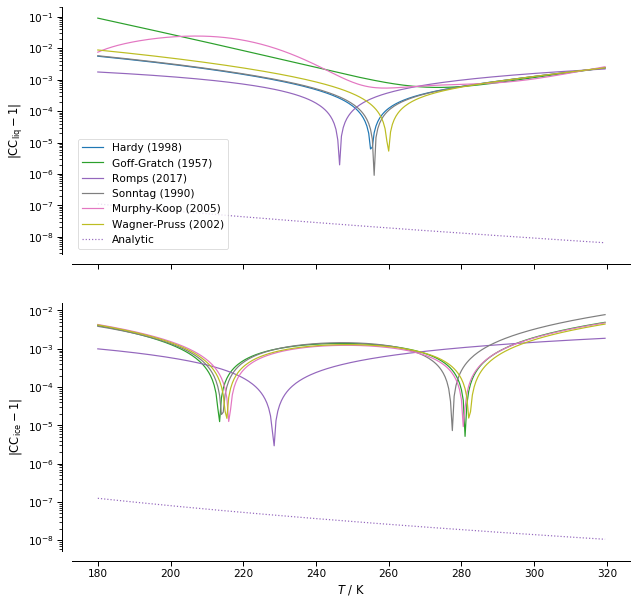

In [7]:
state = 'liq'

fig = plt.figure(figsize=(10,10))

ax1 = plt.subplot(2,1,1)

ax1.set_ylabel('$|\mathrm{CC}_\mathrm{liq} - 1|$')
ax1.set_yscale('log')
ax1.set_xticklabels([])

TK = np.arange(180,320,0.5)

lv   = phase_change_enthalpy(TK)
if (state == 'ice'): lv += phase_change_enthalpy(TK,fusion=True)

y    = lv/(Rv * TK)
cc_w = dlnesdlnT(TK,formula="wagner-pruss",state=state) / y
cc_r = dlnesdlnT(TK,formula='romps',state=state) /y
cc_g = dlnesdlnT(TK,formula='goff-gratch',state=state) /y
cc_m = dlnesdlnT(TK,formula='murphy-koop',state=state) /y
cc_s = dlnesdlnT(TK,formula='sonntag',state=state) /y
cc_h = dlnesdlnT(TK,formula='hardy98',state=state) /y
cc_a = dlnesdlnT(TK,formula='standard-analytic',state=state) /y

plt.plot(TK,np.abs(cc_h/1 -1.),c='tab:blue',label='Hardy (1998)')
plt.plot(TK,np.abs(cc_g/1 -1.),c='tab:green',label='Goff-Gratch (1957)')
plt.plot(TK,np.abs(cc_r/1 -1.),c='tab:purple',label='Romps (2017)')
plt.plot(TK,np.abs(cc_s/1 -1.),c='tab:grey',label='Sonntag (1990)')
plt.plot(TK,np.abs(cc_m/1 -1.),c='tab:pink',label='Murphy-Koop (2005)')
plt.plot(TK,np.abs(cc_w/1 -1.),c='tab:olive',label='Wagner-Pruss (2002)')
plt.plot(TK,np.abs(cc_a/1 -1.),c='tab:purple',ls='dotted',label='Analytic')

plt.legend(loc="lower left",ncol=1)

state = 'ice'
TK = np.arange(180,320,0.5)

lv   = phase_change_enthalpy(TK)
if (state == 'ice'): lv   = phase_change_enthalpy(TK,fusion=True) + phase_change_enthalpy(TK)

y    = lv/(Rv * TK)
cc_w = dlnesdlnT(TK,formula="wagner-pruss",state=state) / y
cc_r = dlnesdlnT(TK,formula='romps',state=state) /y
cc_g = dlnesdlnT(TK,formula='goff-gratch',state=state) /y
cc_m = dlnesdlnT(TK,formula='murphy-koop',state=state) /y
cc_s = dlnesdlnT(TK,formula='sonntag',state=state) /y
cc_a = dlnesdlnT(TK,formula='standard-analytic',state=state) /y

ax2 = plt.subplot(2,1,2)
ax2.set_xlabel('$T$ / K')
ax2.set_ylabel('$|\mathrm{CC}_\mathrm{ice} - 1|$')
ax2.set_yscale('log')

plt.plot(TK,np.abs(cc_g/1 -1.),c='tab:green',label='Goff-Gratch (1957)')
plt.plot(TK,np.abs(cc_r/1 -1.),c='tab:purple',label='Romps (2017)')
plt.plot(TK,np.abs(cc_s/1 -1.),c='tab:grey',label='Sonntag (1990)')
plt.plot(TK,np.abs(cc_m/1 -1.),c='tab:pink',label='Murphy-Koop (2005)')
plt.plot(TK,np.abs(cc_w/1 -1.),c='tab:olive',label='Wagner-Pruss (2002)')
plt.plot(TK,np.abs(cc_a/1. -1.),c='tab:purple',ls='dotted',label='Analytic')

sns.set_context("paper", font_scale=1.2)
sns.despine(offset=10)

fig.savefig(plot_dir+'cc-error.pdf')

## Optimizing analytic fits for saturation vapor pressure ##

Romps suggests modifying the specific heats of liquid, ice and the gas constant of vapor to arrive at an optimal fit for the saturation vapor pressure using the analytic form.  One can do almost as good by just modifying the specific heat of the condensate phases.  Here we show how the maximum error in the fit depends on the specific heat of the condensate phases as compared to the reference, and how we arrive at our optimal fit by only manipulating the condensate phase specific heats to values that they anyway adopt within the range of temperatures spanned by the atmosphere.  This justifys the default choice for saturation vapor pressure and the specific heats used in aes_thermo.py


Taking fit for $c_\mathrm{liq}=$ 4179.57 J/(kg K) at $T=$ 305.00 K
Taking fit for $c_\mathrm{ice}=$ 1905.43 J/(kg K) at $T=$ 247.06 K


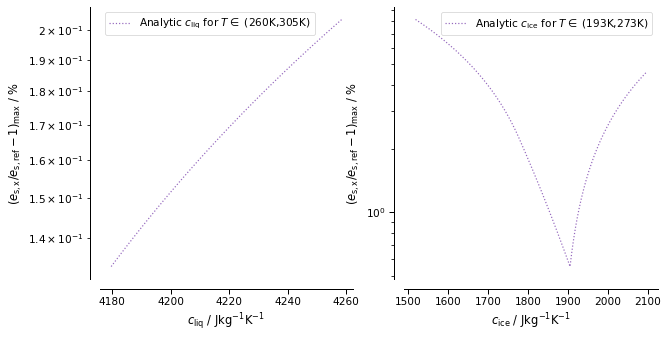

In [8]:
fig = plt.figure(figsize=(10,5))

cl_1 = (iapws._iapws._Liquid(265, 0.1)['cp'])*1000.
cl_2 = (iapws._iapws._Liquid(305, 0.1)['cp'])*1000
ci_1 = (iapws._iapws._Ice(193, 0.01)['cp'])*1000.
ci_2 = (iapws._iapws._Ice(273, 0.10)['cp'])*1000

cls = np.arange(cl_2,cl_1)
err = np.zeros(len(cls))

ax1 = plt.subplot(1,2,1)
ax1.set_xlabel('$c_\mathrm{liq}$ / Jkg$^{-1}$K$^{-1}$')
ax1.set_ylabel('$(e_{\mathrm{s,x}}/e_{\mathrm{s,ref}} - 1)_\mathrm{max}$ / %')
ax1.set_yscale('log')

state = 'liq'
TK = np.arange(260,300,0.5)
es_ref = es(TK,formula="wagner-pruss",state=state)
for i,cx in enumerate(cls):
    c1 = (cpv-cx)/Rv
    c2 = lvT/(Rv*TvT) - c1
    es_a = PvT * np.exp(c2*(1.-TvT/TK)) * (TK/TvT)**c1
    err[i] = np.max(np.abs(es_a/es_ref -1.))*100.
ax1.plot(cls,err,c='tab:purple',ls='dotted',label='Analytic $c_\mathrm{liq}$ for $T\in$ (260K,305K)')
ax1.legend(loc="upper left",ncol=2)

cis = np.arange(ci_1,ci_2)
err = np.zeros(len(cis))

ax2 = plt.subplot(1,2,2)
ax2.set_xlabel('$c_\mathrm{ice}$ / Jkg$^{-1}$K$^{-1}$')
ax2.set_ylabel('$(e_{\mathrm{s,x}}/e_{\mathrm{s,ref}} - 1)_\mathrm{max}$ / %')
ax2.set_yscale('log')

state = 'ice'
TK = np.arange(180,273,0.5)
es_ref = es(TK,formula="wagner-pruss",state=state)
for i,cx in enumerate(cis):
    c1 = (cpv-cx)/Rv
    c2 = lsT/(Rv*TvT) - c1
    es_a = PvT * np.exp(c2*(1.-TvT/TK)) * (TK/TvT)**c1
    err[i] = np.max(np.abs(es_a/es_ref -1.))*100.
ax2.plot(cis,err,c='tab:purple',ls='dotted',label='Analytic $c_\mathrm{ice}$ for $T\in$ (193K,273K)')
ax2.legend(loc="upper right",ncol=2)

sns.set_context("paper", font_scale=1.2)
sns.despine(offset=10)

fig.savefig(plot_dir+'es-analytic-fits.pdf')
Tfit = 305
print ('Taking fit for $c_\mathrm{liq}=$ %3.2f J/(kg K) at $T=$ %3.2f K'%(iapws._iapws._Liquid(Tfit, 0.1)['cp']*1000.,Tfit))
Tfit = 247.065
print ('Taking fit for $c_\mathrm{ice}=$ %3.2f J/(kg K) at $T=$ %3.2f K'%(iapws._iapws._Ice(Tfit, 0.1)['cp']*1000.,Tfit))

## RCEMIP comparision ##

During RCEMIP (Wing et al.) different models output different RH, differing in ways of calculating it and also whether or not it was calculated relative to liquid or ice.  In this analysis we create a python implementation of the intial RCEMIP sounding and then for the given state estimate the RH using different formulat and different assumptions regarding the reference condensate (liquid/ice).  We also show the difference associated with 1 K of temperature. 

In [9]:
def rcemip_on_z(z,SST):
    # function [T,q,p] = rcemip_on_z(z,SST)
    # 
    # Inputs:
    # z: array of heights (low to high, m)
    # SST: sea surface temperature (K)
    # 
    # Outputs:
    T = np.zeros(len(z)) # temperature (K)
    q = np.zeros(len(z)) # specific humidity (g/g)
    p = np.zeros(len(z)) # pressure (Pa)

    ## Constants
    g = 9.79764 #m/s^2
    Rd = 287.04 #J/kgK
    
    ## Parameters
    p0 = 101480   #Pa surface pressure
    qt = 10**(-11) #g/g specific humidity at tropopause
    zq1 = 4000 #m
    zq2 = 7500 #m
    zt = 15000 #m tropopause height
    gamma = 0.0067 #K/m lapse rate
    
    ## Scratch
    Tv = np.zeros(len(z)) # temperature (K)

    if SST == 295:
        q0 = 0.01200; #g/g specific humidity at surface (adjusted from 300K value so RH near surface approx 80%)
    elif SST == 300:
        q0 = 0.01865; #g/g specific humidity at surface
    elif SST == 305:
        q0 = 0.02400 #g/g specific humidity at surface (adjusted from 300K value so RH near surface approx 80%)
    
    T0 = SST - 0 #surface air temperature adjusted to be 0K less than SST
    
    ## Virtual Temperature at surface and tropopause
    Tv0 = T0*(1 + 0.608*q0) #virtual temperature at surface
    Tvt = Tv0 - gamma*zt #virtual temperature at tropopause z=zt
    
    ## Pressure
    pt = p0*(Tvt/Tv0)**(g/(Rd*gamma)); #pressure at tropopause z=zt
    p  = p0*((Tv0-gamma*z)/Tv0)**(g/(Rd*gamma)) #0 <= z <= zt
    p[z>zt] = pt*np.exp(-g*(z[z>zt]-zt)/(Rd*Tvt)) #z > zt
    
    ## Specific humidity
    q = q0*np.exp(-z/zq1)*np.exp(-(z/zq2)**2)
    q[z>zt] = qt #z > zt
    
    ## Temperature
    #Virtual Temperature
    Tv = Tv0 - gamma*z #0 <= z <= zt
    Tv[z>zt] = Tvt #z > zt
    
    #Absolute Temperature at all heights
    T = Tv/(1 + 0.608*q)
    
    return T, q, p

z = np.arange(0,17000,100)
T, q , p = rcemip_on_z(z,300)

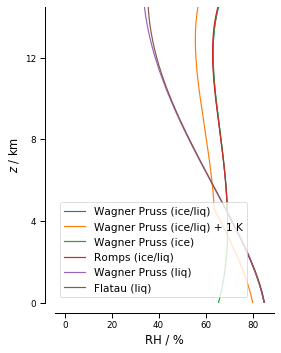

In [10]:
def get_rh (T,q,p,formula='wagner-pruss',state='liq'):
    es_w = es(T,formula=formula,state=state)
    x = es_w * eps1/(p-es_w)
    return 100.*q*(1+x)/x
    
fig = plt.figure(figsize=(4,5))

ax1 = plt.subplot(1,1,1)
ax1.set_ylabel('$z$ / km')
ax1.set_xlabel('RH / %')
ax1.set_ylim(0,14.5)
ax1.set_yticks([0,4,8,12])

plt.plot(get_rh(T,q,p,state='mxd'),z/1000.,label = 'Wagner Pruss (ice/liq)')
plt.plot(get_rh(T+1,q,p,state='mxd'),z/1000.,label = 'Wagner Pruss (ice/liq) + 1 K')
plt.plot(get_rh(T,q,p,state='ice'),z/1000.,label = 'Wagner Pruss (ice)')
plt.plot(get_rh(T,q,p,formula='romps',state='mxd'),z/1000.,label = 'Romps (ice/liq)')
plt.plot(get_rh(T,q,p),z/1000.,label = 'Wagner Pruss (liq)')
plt.plot(get_rh(T,q,p,formula='flatau'),z/1000.,label = 'Flatau (liq)')

plt.legend(loc="lower left",ncol=1)

sns.set_context("paper")
sns.despine(offset=10)
plt.tight_layout()

fig.savefig(plot_dir+'RCEMIP-RHerror.pdf')

## Credit ##

Jiawei Bao, Geet George, and Hauke Schulz are thanked for comments on these notes, and the identification of some errors in earlier versions.